### MIL with Molecular Fragments (Additive Properties)

In this tutorial, we focus on a **Multiple Instance Learning (MIL)** setup where each **bag** represents a collection of molecular fragments, and the **bag-level label** is computed as the sum of some **additive property** across the fragments.  

This setup is useful for tasks where molecular properties can be approximated as a **linear combination of fragment contributions**, such as LogP or other physicochemical properties.

---

### Key Concepts

- **Instance:** A single molecular fragment, e.g., `C(=O)O` (carboxy group).  
- **Bag:** A collection of fragments, e.g., a list of 5 fragments forming a small molecule.  
- **Label:** Sum of the property values of all fragments in the bag. For example, the sum of LogP contributions.  
- **Key Instance:** In this tutorial, **all fragments are considered key instances**, since every fragment contributes to the bag-level label.  

---

### Goals of this Notebook

1. Represent molecules as **bags of fragments**.  
2. Compute fragment-level properties that contribute additively to the bag label.  
3. Train MIL models to predict **bag-level properties** while recovering **fragment contributions**.  
4. Analyze predicted weights to identify **key fragments** and evaluate model interpretability.


In [1]:
import logging
import warnings
warnings.filterwarnings("ignore")
logging.getLogger("pytorch_lightning").setLevel(logging.ERROR)
logging.getLogger("lightning").setLevel(logging.ERROR)
from rdkit import RDLogger
# Suppress all RDKit warnings
RDLogger.DisableLog('rdApp.*')

import time
import torch
import random

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

# Preprocessing
from milearn.preprocessing import BagMinMaxScaler

# Network hparams
from milearn.network.module.hopt import DEFAULT_PARAM_GRID

# MIL wrappers
from milearn.network.regressor import BagWrapperMLPNetworkRegressor, InstanceWrapperMLPNetworkRegressor
from milearn.network.classifier import BagWrapperMLPNetworkClassifier, InstanceWrapperMLPNetworkClassifier

# MIL networks
from milearn.network.regressor import (InstanceNetworkRegressor,
                                       BagNetworkRegressor,
                                       AdditiveAttentionNetworkRegressor,
                                       SelfAttentionNetworkRegressor,
                                       HopfieldAttentionNetworkRegressor,
                                       DynamicPoolingNetworkRegressor)

# Utils
from scipy.stats import spearmanr
from sklearn.metrics import r2_score, accuracy_score
from sklearn.model_selection import train_test_split

# Molecular utils
from qsarmil.fragment.rdkit import FragmentGenerator
from rdkit.Chem import Descriptors, rdMolDescriptors
from rdkit import Chem
from rdkit.Chem import AllChem

# Prediction visualisation
from rdkit.Chem import Draw
import numpy as np
import matplotlib.pyplot as plt

# Data
from huggingface_hub import hf_hub_download

### Key Instance Ranking Accuracy (`kid_ranking_accuracy`)

In MIL tasks where **instance-level contributions** are predicted (e.g., via attention weights), it is useful to measure **how well the predicted weights rank the true contributions**.  

The function `kid_ranking_accuracy` computes a **ranking-based accuracy metric** using **Spearman correlation** between predicted weights and true instance contributions:

---

### How It Works

1. **Inputs:**
   - `instance_digits` – true property values or contributions for each instance in a bag (e.g., fragment property values).  
   - `attn_weights` – predicted weights from the MIL model (e.g., attention scores).

2. **Per-bag correlation:**
   - For each bag, compute the **Spearman rank correlation** between predicted weights and true instance contributions.  
   - If all true contributions are identical (no variance), correlation is undefined → assign `0.0`.  
   - Any `NaN` correlation is also replaced with `0.0`.

3. **Output:**
   - Returns the **mean Spearman correlation** across all bags.  
   - This metric reflects how well the model **ranks instances by their true importance**, not just whether it identifies the top instance.

---

### Interpretation

- `1.0` → Perfect ranking: predicted weights exactly match the true contributions.  
- `0.0` → No correlation between predicted weights and true contributions.  
- `-1.0` → Completely inverted ranking.  

This metric is particularly useful for **evaluating interpretability** of MIL models at the instance level.

In [2]:
def kid_ranking_accuracy(instance_digits, attn_weights):

    per_bag_corrs = []
    for w, digits in zip(attn_weights, instance_digits):
        if len(set(digits)) == 1:
            # Avoid undefined correlation when all digits are identical
            per_bag_corrs.append(0.0)
            continue

        corr, _ = spearmanr(w, digits)
        if np.isnan(corr):
            corr = 0.0
        per_bag_corrs.append(corr)

    mean_corr = np.mean(per_bag_corrs)
    return mean_corr

### Fragment Properties in MIL

In this MIL setup, each bag represents a collection of **molecular fragments**, and the bag-level label is derived from the **sum of fragment properties**.

- Molecules are broken into **BRICS fragments**.  
- A fixed number of fragments are randomly sampled to form a bag.  
- A chemical property is calculated for each fragment.

**Fragment properties used:**

- `LogP` – Lipophilicity  
- `MolWt` – Molecular weight  
- `TPSA` – Topological polar surface area  
- `NumHDonors` – Hydrogen bond donors  
- `NumHAcceptors` – Hydrogen bond acceptors  
- `MolMR` – Molar refractivity  
- `NumRotatableBonds` – Flexibility  
- `RingCount` – Number of rings  
- `FractionCSP3` – Fraction of sp³-hybridized carbons

The **bag label** is the sum of the selected fragment properties.  

**Function output:**
1. Fragment bags (RDKit Mol objects)  
2. Bag labels (sum of properties)  
3. Individual fragment properties per bag


In [3]:
def display_fragments_with_weights(fragments, props, pred_weights, sort=True, max_fragments=16, title=None):

    props = np.array(props)
    pred_weights = np.array(pred_weights)

    if sort:
        sorted_idx = np.argsort(props)[::-1]
        fragments = [fragments[i] for i in sorted_idx]
        props = props[sorted_idx]
        pred_weights = pred_weights[sorted_idx]

    fragments = fragments[:max_fragments]
    props = props[:max_fragments]
    pred_weights = pred_weights[:max_fragments]

    cols = 4
    rows = (len(fragments) + cols - 1) // cols

    fig, axes = plt.subplots(rows, cols, figsize=(cols * 3, rows * 3))
    axes = axes.flatten()

    for ax in axes[len(fragments):]:
        ax.axis('off')

    for i, (frag, prop, weight) in enumerate(zip(fragments, props, pred_weights)):
        ax = axes[i]
        img = Draw.MolToImage(frag, size=(150, 150))
        ax.imshow(img)
        ax.set_title(f"True prop: {prop:.3f}\nWeight: {weight:.2f}", fontsize=10)
        ax.axis('off')

    if title:
        fig.suptitle(title, fontsize=16)

    plt.tight_layout(rect=[0, 0, 1, 0.95])  # leave space for suptitle
    plt.show()

In [4]:
# Supported RDKit molecular property functions
PROPERTY_FUNCTIONS = {
    "LogP": Descriptors.MolLogP,
    "MolWt": Descriptors.MolWt,
    "TPSA": rdMolDescriptors.CalcTPSA,
    "NumHDonors": Descriptors.NumHDonors,
    "NumHAcceptors": Descriptors.NumHAcceptors,
    "MolMR": Descriptors.MolMR,
    "NumRotatableBonds": Descriptors.NumRotatableBonds,
    "RingCount": Descriptors.RingCount,
    "FractionCSP3": Descriptors.FractionCSP3,
}

### 1. Load dataset

In [5]:
REPO_ID = "KagakuData/notebooks"

csv_path = hf_hub_download(REPO_ID, filename="chembl/CHEMBL217.csv", repo_type="dataset")
data = pd.read_csv(csv_path, header=None)

smiles = list(data[0])
mols = [Chem.MolFromSmiles(s) for s in smiles]

### 2. Generate molecular fragments

In [6]:
# generate fragments
frag_gen = FragmentGenerator(num_cpu=40, verbose=True)
frags = frag_gen.run(mols)

# sample bags with multiple fragments
bag_size = 5
rng = np.random.RandomState(42)
frags = [mol for mol in frags if len(mol) > bag_size]
frags = [rng.choice(mol, size=bag_size, replace=False).tolist() for mol in frags]

Generating fragments: 100%|█████████████████████████████████████████████████████████| 5012/5012 [08:46<00:00,  9.52it/s]


In [7]:
property_name = "LogP"
get_property = PROPERTY_FUNCTIONS[property_name]

contribs = [[get_property(f) for f in mol] for mol in frags]
props = [sum(m) for m in contribs]

In [8]:
print(f"Total number of molecules: {len(mols)}")
print(f"Total number of bags (successfully generated fragments): {len(frags)}")

Total number of molecules: 5012
Total number of bags (successfully generated fragments): 2582


In [9]:
frags[0]

In [10]:
contribs[0]

[-0.11459999999999992,
 -0.46740000000000004,
 -0.12270000000000003,
 -0.4954,
 0.03579999999999994]

In [11]:
props[0]

-1.1643

### 3. Calculate fragment descriptors

In [12]:
def compute_fragment_descriptors(frags, n_bits=128, radius=2):
    bags_descriptors = []
    for frag in frags:
        descs = [np.array(AllChem.GetMorganFingerprintAsBitVect(f, radius, nBits=n_bits)) for f in frag]
        bags_descriptors.append(descs)
    return bags_descriptors

In [13]:
desc = compute_fragment_descriptors(frags)

### 4. Model training

In [14]:
x_train, x_test, y_train, y_test, key_train, key_test, frg_train, frg_test = train_test_split(desc, props, contribs, frags, random_state=42)
#
scaler = BagMinMaxScaler()
scaler.fit(x_train)
x_train_scaled = scaler.transform(x_train)
x_test_scaled = scaler.transform(x_test)

In [15]:
model = DynamicPoolingNetworkRegressor()
model.hopt(x_train_scaled, y_train, param_grid=DEFAULT_PARAM_GRID, verbose=True)
model.fit(x_train_scaled, y_train)

Optimizing hyperparameter: hidden_layer_sizes (3 options)
[1/28 |  3.6% | 18.1 min] Value: (2048, 1024, 512, 256, 128, 64), Epochs: 35, Loss: 0.0033
[2/28 |  7.1% | 17.3 min] Value: (256, 128, 64), Epochs: 58, Loss: 0.0027
[3/28 | 10.7% | 10.9 min] Value: (128,), Epochs: 64, Loss: 0.0045
Best hidden_layer_sizes = (256, 128, 64), val_loss = 0.0027
Optimizing hyperparameter: activation (5 options)
[4/28 | 14.3% | 21.9 min] Value: relu, Epochs: 46, Loss: 0.0039
[5/28 | 17.9% | 23.7 min] Value: leakyrelu, Epochs: 52, Loss: 0.0039
[6/28 | 21.4% | 23.7 min] Value: gelu, Epochs: 51, Loss: 0.0028
[7/28 | 25.0% | 17.1 min] Value: elu, Epochs: 33, Loss: 0.0054
[8/28 | 28.6% | 23.7 min] Value: silu, Epochs: 67, Loss: 0.0032
Best activation = gelu, val_loss = 0.0028
Optimizing hyperparameter: learning_rate (2 options)
[9/28 | 32.1% | 76.1 min] Value: 0.0001, Epochs: 180, Loss: 0.0030
[10/28 | 35.7% | 33.3 min] Value: 0.001, Epochs: 42, Loss: 0.0028
Best learning_rate = 0.001, val_loss = 0.0028
Opt

DynamicPoolingNetworkRegressor(
  (instance_transformer): Sequential(
    (0): Linear(in_features=128, out_features=256, bias=True)
    (1): GELU(approximate='none')
    (2): Linear(in_features=256, out_features=128, bias=True)
    (3): GELU(approximate='none')
    (4): Linear(in_features=128, out_features=64, bias=True)
    (5): GELU(approximate='none')
  )
  (bag_estimator): Norm()
  (dynamic_pooling): DynamicPooling()
)

In [16]:
y_pred = model.predict(x_test_scaled)
w_pred = model.get_instance_weights(x_test_scaled)
w_pred = [w.flatten() for w in w_pred]

In [17]:
print(f"Regression R2: {r2_score(y_test, y_pred):.2f}")
print(f"KID ranking accuracy: {kid_ranking_accuracy(key_test, w_pred):.2f}")

Regression R2: 0.71
KID ranking accuracy: 0.79


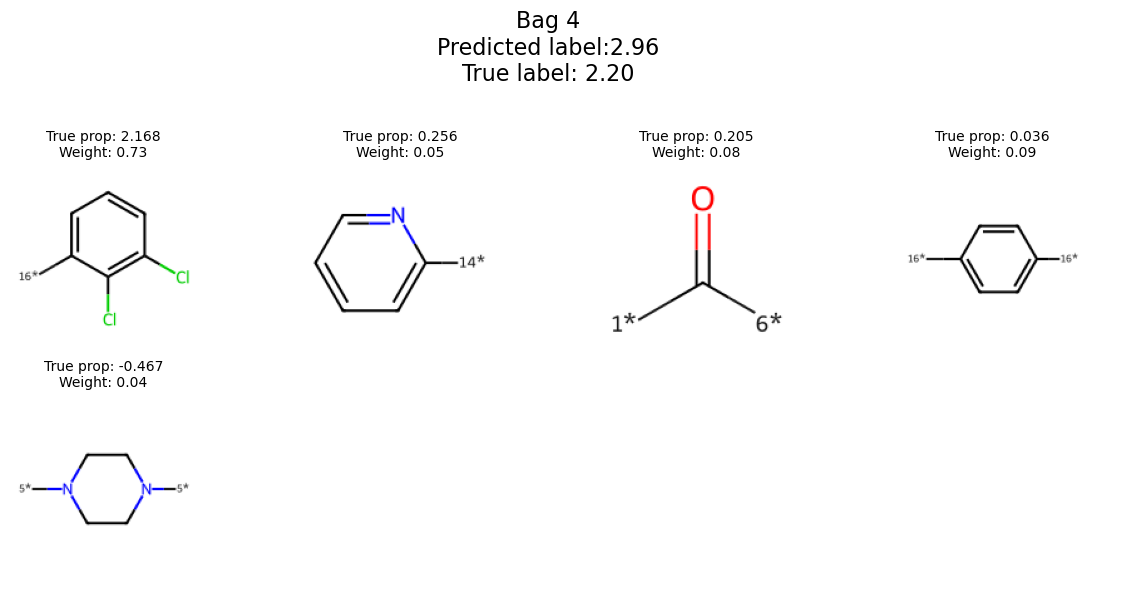

In [18]:
N = 4
display_fragments_with_weights(frg_test[N], key_test[N], w_pred[N], sort=True, max_fragments=10,
                               title=f"Bag {N}\nPredicted label:{y_pred[N].item():.2f}\nTrue label: {y_test[N]:.2f}")

### 4. Mini-benchmark

In [19]:
regressor_list = [
    
        # attention mil networks
        ("AdditiveAttentionNetworkRegressor", AdditiveAttentionNetworkRegressor()),
        ("SelfAttentionNetworkRegressor", SelfAttentionNetworkRegressor()),
        ("HopfieldAttentionNetworkRegressor", HopfieldAttentionNetworkRegressor()),

        # other mil networks
        ("DynamicPoolingNetworkRegressor", DynamicPoolingNetworkRegressor()),
    ]

In [20]:
bag_size = 5

res_df = pd.DataFrame()
tasks = ["LogP", "MolWt", "TPSA", "NumHDonors", "NumHAcceptors", 
         "MolMR", "NumRotatableBonds", "RingCount", "FractionCSP3"]

for task_idx, task in enumerate(tasks, 1):
    print(f"\n[Task {task_idx}/{len(tasks)}] Starting task: '{task}'")

    # load data
    REPO_ID = "KagakuData/notebooks"
    csv_path = hf_hub_download(REPO_ID, filename="chembl/CHEMBL279.csv", repo_type="dataset")
    data = pd.read_csv(csv_path, header=None)
    smiles = list(data[0])
    mols = [Chem.MolFromSmiles(s) for s in smiles]

    # compute bag desc
    frag_gen = FragmentGenerator(num_cpu=40, verbose=True)
    frags = frag_gen.run(mols)
    #
    bag_size = 5
    rng = np.random.RandomState(42)
    frags = [mol for mol in frags if len(mol) > bag_size]
    frags = [rng.choice(mol, size=bag_size, replace=False).tolist() for mol in frags]
    #
    get_property = PROPERTY_FUNCTIONS[task]
    contribs = [[get_property(f) for f in mol] for mol in frags]
    props = [sum(m) for m in contribs]
    #
    desc = compute_fragment_descriptors(frags)
    #
    x_train, x_test, y_train, y_test, key_train, key_test, frg_train, frg_test = train_test_split(
        desc, props, contribs, frags, random_state=42)
    
    # scale features
    scaler = BagMinMaxScaler()
    scaler.fit(x_train)
    x_train_scaled, x_test_scaled = scaler.transform(x_train), scaler.transform(x_test)
    
    # build models
    for model_idx, (name, model) in enumerate(regressor_list, 1):
        print(f"  [Model {model_idx}/{len(regressor_list)}] Training model: '{name}'")

        # train model
        model.hopt(x_train_scaled, y_train, param_grid=DEFAULT_PARAM_GRID, verbose=True)
        model.fit(x_train_scaled, y_train)
        
        # predict
        y_pred = model.predict(x_test_scaled)
        w_pred = model.get_instance_weights(x_test_scaled)
        w_pred = [w.flatten() for w in w_pred]
        #
        res_df.loc[name, f"PRED_{task}"] = r2_score(y_test, y_pred)
        res_df.loc[name, f"KID_{task}"] = kid_ranking_accuracy(key_test, w_pred)

print("\nAll tasks and models completed.")


[Task 1/9] Starting task: 'LogP'


Generating fragments: 100%|███████████████████████████████████████████████████████████| 672/672 [00:25<00:00, 25.96it/s]


  [Model 1/4] Training model: 'AdditiveAttentionNetworkRegressor'
Optimizing hyperparameter: hidden_layer_sizes (3 options)
[1/31 |  3.2% |  0.9 min] Value: (2048, 1024, 512, 256, 128, 64), Epochs: 34, Loss: 0.4843
[2/31 |  6.5% |  0.5 min] Value: (256, 128, 64), Epochs: 45, Loss: 0.6243
[3/31 |  9.7% |  0.6 min] Value: (128,), Epochs: 64, Loss: 1.2810
Best hidden_layer_sizes = (2048, 1024, 512, 256, 128, 64), val_loss = 0.4843
Optimizing hyperparameter: activation (5 options)
[4/31 | 12.9% |  1.4 min] Value: relu, Epochs: 60, Loss: 0.6040
[5/31 | 16.1% |  2.2 min] Value: leakyrelu, Epochs: 104, Loss: 0.4800
[6/31 | 19.4% |  1.1 min] Value: gelu, Epochs: 47, Loss: 0.4927
[7/31 | 22.6% |  1.7 min] Value: elu, Epochs: 73, Loss: 0.6336
[8/31 | 25.8% |  1.8 min] Value: silu, Epochs: 76, Loss: 0.4185
Best activation = silu, val_loss = 0.4185
Optimizing hyperparameter: learning_rate (2 options)
[9/31 | 29.0% |  1.5 min] Value: 0.0001, Epochs: 52, Loss: 0.5392
[10/31 | 32.3% |  1.0 min] Value

Generating fragments: 100%|███████████████████████████████████████████████████████████| 672/672 [00:21<00:00, 30.95it/s]


  [Model 1/4] Training model: 'AdditiveAttentionNetworkRegressor'
Optimizing hyperparameter: hidden_layer_sizes (3 options)
[1/31 |  3.2% |  0.8 min] Value: (2048, 1024, 512, 256, 128, 64), Epochs: 44, Loss: 1275.9178
[2/31 |  6.5% |  0.9 min] Value: (256, 128, 64), Epochs: 119, Loss: 1064.6215
[3/31 |  9.7% |  2.0 min] Value: (128,), Epochs: 435, Loss: 4480.3716
Best hidden_layer_sizes = (256, 128, 64), val_loss = 1064.6215
Optimizing hyperparameter: activation (5 options)
[4/31 | 12.9% |  0.8 min] Value: relu, Epochs: 122, Loss: 830.3524
[5/31 | 16.1% |  0.8 min] Value: leakyrelu, Epochs: 126, Loss: 847.7144
[6/31 | 19.4% |  0.7 min] Value: gelu, Epochs: 113, Loss: 896.3862
[7/31 | 22.6% |  0.6 min] Value: elu, Epochs: 93, Loss: 1019.2482
[8/31 | 25.8% |  0.8 min] Value: silu, Epochs: 118, Loss: 922.1566
Best activation = relu, val_loss = 830.3524
Optimizing hyperparameter: learning_rate (2 options)
[9/31 | 29.0% |  2.4 min] Value: 0.0001, Epochs: 381, Loss: 3454.3811
[10/31 | 32.3% 

Generating fragments: 100%|███████████████████████████████████████████████████████████| 672/672 [00:15<00:00, 43.38it/s]


  [Model 1/4] Training model: 'AdditiveAttentionNetworkRegressor'
Optimizing hyperparameter: hidden_layer_sizes (3 options)
[1/31 |  3.2% |  0.7 min] Value: (2048, 1024, 512, 256, 128, 64), Epochs: 54, Loss: 94.7771
[2/31 |  6.5% |  0.2 min] Value: (256, 128, 64), Epochs: 28, Loss: 245.9736
[3/31 |  9.7% |  0.2 min] Value: (128,), Epochs: 43, Loss: 347.3000
Best hidden_layer_sizes = (2048, 1024, 512, 256, 128, 64), val_loss = 94.7771
Optimizing hyperparameter: activation (5 options)
[4/31 | 12.9% |  0.9 min] Value: relu, Epochs: 57, Loss: 109.8288
[5/31 | 16.1% |  0.7 min] Value: leakyrelu, Epochs: 40, Loss: 94.2263
[6/31 | 19.4% |  0.5 min] Value: gelu, Epochs: 26, Loss: 101.8193
[7/31 | 22.6% |  0.5 min] Value: elu, Epochs: 23, Loss: 216.2474
[8/31 | 25.8% |  0.9 min] Value: silu, Epochs: 48, Loss: 160.6714
Best activation = leakyrelu, val_loss = 94.2263
Optimizing hyperparameter: learning_rate (2 options)
[9/31 | 29.0% |  0.6 min] Value: 0.0001, Epochs: 35, Loss: 230.5230
[10/31 | 3

Generating fragments: 100%|███████████████████████████████████████████████████████████| 672/672 [00:18<00:00, 36.05it/s]


  [Model 1/4] Training model: 'AdditiveAttentionNetworkRegressor'
Optimizing hyperparameter: hidden_layer_sizes (3 options)
[1/31 |  3.2% |  0.3 min] Value: (2048, 1024, 512, 256, 128, 64), Epochs: 25, Loss: 0.1037
[2/31 |  6.5% |  0.2 min] Value: (256, 128, 64), Epochs: 32, Loss: 0.2516
[3/31 |  9.7% |  0.1 min] Value: (128,), Epochs: 17, Loss: 0.5714
Best hidden_layer_sizes = (2048, 1024, 512, 256, 128, 64), val_loss = 0.1037
Optimizing hyperparameter: activation (5 options)
[4/31 | 12.9% |  0.8 min] Value: relu, Epochs: 64, Loss: 0.0837
[5/31 | 16.1% |  0.6 min] Value: leakyrelu, Epochs: 29, Loss: 0.1084
[6/31 | 19.4% |  0.5 min] Value: gelu, Epochs: 25, Loss: 0.1075
[7/31 | 22.6% |  0.5 min] Value: elu, Epochs: 20, Loss: 0.1774
[8/31 | 25.8% |  0.5 min] Value: silu, Epochs: 30, Loss: 0.0985
Best activation = relu, val_loss = 0.0837
Optimizing hyperparameter: learning_rate (2 options)
[9/31 | 29.0% |  0.6 min] Value: 0.0001, Epochs: 43, Loss: 0.1279
[10/31 | 32.3% |  0.4 min] Value:

Generating fragments: 100%|███████████████████████████████████████████████████████████| 672/672 [00:17<00:00, 39.18it/s]


  [Model 1/4] Training model: 'AdditiveAttentionNetworkRegressor'
Optimizing hyperparameter: hidden_layer_sizes (3 options)
[1/31 |  3.2% |  0.5 min] Value: (2048, 1024, 512, 256, 128, 64), Epochs: 153, Loss: 0.2044
[2/31 |  6.5% |  0.0 min] Value: (256, 128, 64), Epochs: 22, Loss: 1.3123
[3/31 |  9.7% |  0.1 min] Value: (128,), Epochs: 42, Loss: 1.9235
Best hidden_layer_sizes = (2048, 1024, 512, 256, 128, 64), val_loss = 0.2044
Optimizing hyperparameter: activation (5 options)
[4/31 | 12.9% |  1.0 min] Value: relu, Epochs: 181, Loss: 0.1492
[5/31 | 16.1% |  0.9 min] Value: leakyrelu, Epochs: 145, Loss: 0.1993
[6/31 | 19.4% |  0.7 min] Value: gelu, Epochs: 107, Loss: 0.1775
[7/31 | 22.6% |  0.8 min] Value: elu, Epochs: 89, Loss: 0.2894
[8/31 | 25.8% |  1.1 min] Value: silu, Epochs: 203, Loss: 0.1919
Best activation = relu, val_loss = 0.1492
Optimizing hyperparameter: learning_rate (2 options)
[9/31 | 29.0% |  1.9 min] Value: 0.0001, Epochs: 435, Loss: 0.3112
[10/31 | 32.3% |  0.8 min] 

Generating fragments: 100%|███████████████████████████████████████████████████████████| 672/672 [00:19<00:00, 34.23it/s]


  [Model 1/4] Training model: 'AdditiveAttentionNetworkRegressor'
Optimizing hyperparameter: hidden_layer_sizes (3 options)
[1/31 |  3.2% |  0.7 min] Value: (2048, 1024, 512, 256, 128, 64), Epochs: 49, Loss: 16.9680
[2/31 |  6.5% |  0.6 min] Value: (256, 128, 64), Epochs: 98, Loss: 31.4207
[3/31 |  9.7% |  0.6 min] Value: (128,), Epochs: 114, Loss: 314.4533
Best hidden_layer_sizes = (2048, 1024, 512, 256, 128, 64), val_loss = 16.9680
Optimizing hyperparameter: activation (5 options)
[4/31 | 12.9% |  1.2 min] Value: relu, Epochs: 69, Loss: 13.4559
[5/31 | 16.1% |  1.5 min] Value: leakyrelu, Epochs: 98, Loss: 12.6059
[6/31 | 19.4% |  1.1 min] Value: gelu, Epochs: 72, Loss: 11.5136
[7/31 | 22.6% |  0.7 min] Value: elu, Epochs: 41, Loss: 27.8447
[8/31 | 25.8% |  1.1 min] Value: silu, Epochs: 76, Loss: 16.6317
Best activation = gelu, val_loss = 11.5136
Optimizing hyperparameter: learning_rate (2 options)
[9/31 | 29.0% |  2.1 min] Value: 0.0001, Epochs: 204, Loss: 24.1737
[10/31 | 32.3% |  1

Generating fragments: 100%|███████████████████████████████████████████████████████████| 672/672 [00:14<00:00, 46.13it/s]


  [Model 1/4] Training model: 'AdditiveAttentionNetworkRegressor'
Optimizing hyperparameter: hidden_layer_sizes (3 options)
[1/31 |  3.2% |  0.2 min] Value: (2048, 1024, 512, 256, 128, 64), Epochs: 24, Loss: 0.2002
[2/31 |  6.5% |  0.1 min] Value: (256, 128, 64), Epochs: 19, Loss: 0.1132
[3/31 |  9.7% |  0.1 min] Value: (128,), Epochs: 26, Loss: 0.1460
Best hidden_layer_sizes = (256, 128, 64), val_loss = 0.1132
Optimizing hyperparameter: activation (5 options)
[4/31 | 12.9% |  0.1 min] Value: relu, Epochs: 15, Loss: 0.1711
[5/31 | 16.1% |  0.1 min] Value: leakyrelu, Epochs: 16, Loss: 0.1532
[6/31 | 19.4% |  0.1 min] Value: gelu, Epochs: 15, Loss: 0.1361
[7/31 | 22.6% |  0.1 min] Value: elu, Epochs: 21, Loss: 0.1556
[8/31 | 25.8% |  0.1 min] Value: silu, Epochs: 16, Loss: 0.1295
Best activation = silu, val_loss = 0.1295
Optimizing hyperparameter: learning_rate (2 options)
[9/31 | 29.0% |  0.1 min] Value: 0.0001, Epochs: 43, Loss: 0.1078
[10/31 | 32.3% |  0.1 min] Value: 0.001, Epochs: 1

Generating fragments: 100%|███████████████████████████████████████████████████████████| 672/672 [00:14<00:00, 46.88it/s]


  [Model 1/4] Training model: 'AdditiveAttentionNetworkRegressor'
Optimizing hyperparameter: hidden_layer_sizes (3 options)
[1/31 |  3.2% |  0.3 min] Value: (2048, 1024, 512, 256, 128, 64), Epochs: 35, Loss: 0.4385
[2/31 |  6.5% |  0.3 min] Value: (256, 128, 64), Epochs: 90, Loss: 0.3846
[3/31 |  9.7% |  0.3 min] Value: (128,), Epochs: 90, Loss: 0.8410
Best hidden_layer_sizes = (256, 128, 64), val_loss = 0.3846
Optimizing hyperparameter: activation (5 options)
[4/31 | 12.9% |  0.5 min] Value: relu, Epochs: 96, Loss: 0.3799
[5/31 | 16.1% |  0.5 min] Value: leakyrelu, Epochs: 74, Loss: 0.3589
[6/31 | 19.4% |  0.5 min] Value: gelu, Epochs: 67, Loss: 0.4021
[7/31 | 22.6% |  0.4 min] Value: elu, Epochs: 59, Loss: 0.4323
[8/31 | 25.8% |  0.5 min] Value: silu, Epochs: 75, Loss: 0.4227
Best activation = leakyrelu, val_loss = 0.3589
Optimizing hyperparameter: learning_rate (2 options)
[9/31 | 29.0% |  0.3 min] Value: 0.0001, Epochs: 96, Loss: 0.3765
[10/31 | 32.3% |  0.1 min] Value: 0.001, Epoc

Generating fragments: 100%|███████████████████████████████████████████████████████████| 672/672 [00:14<00:00, 46.98it/s]


  [Model 1/4] Training model: 'AdditiveAttentionNetworkRegressor'
Optimizing hyperparameter: hidden_layer_sizes (3 options)
[1/31 |  3.2% |  1.3 min] Value: (2048, 1024, 512, 256, 128, 64), Epochs: 96, Loss: 0.0349
[2/31 |  6.5% |  0.8 min] Value: (256, 128, 64), Epochs: 111, Loss: 0.1449
[3/31 |  9.7% |  1.0 min] Value: (128,), Epochs: 194, Loss: 0.3112
Best hidden_layer_sizes = (2048, 1024, 512, 256, 128, 64), val_loss = 0.0349
Optimizing hyperparameter: activation (5 options)
[4/31 | 12.9% |  1.3 min] Value: relu, Epochs: 85, Loss: 0.0267
[5/31 | 16.1% |  2.0 min] Value: leakyrelu, Epochs: 126, Loss: 0.0185
[6/31 | 19.4% |  2.2 min] Value: gelu, Epochs: 132, Loss: 0.0408
[7/31 | 22.6% |  2.2 min] Value: elu, Epochs: 138, Loss: 0.0413
[8/31 | 25.8% |  2.4 min] Value: silu, Epochs: 163, Loss: 0.0246
Best activation = leakyrelu, val_loss = 0.0185
Optimizing hyperparameter: learning_rate (2 options)
[9/31 | 29.0% |  1.8 min] Value: 0.0001, Epochs: 164, Loss: 0.0328
[10/31 | 32.3% |  1.2

In [21]:
res_df.round(2)

,PRED_LogP,KID_LogP,PRED_MolWt,KID_MolWt,PRED_TPSA,KID_TPSA,PRED_NumHDonors,KID_NumHDonors,PRED_NumHAcceptors,KID_NumHAcceptors,PRED_MolMR,KID_MolMR,PRED_NumRotatableBonds,KID_NumRotatableBonds,PRED_RingCount,KID_RingCount,PRED_FractionCSP3,KID_FractionCSP3
AdditiveAttentionNetworkRegressor,0.65,0.11,0.92,0.24,0.85,0.36,0.87,0.38,0.92,-0.05,0.96,0.66,0.65,0.12,0.94,0.08,0.99,0.11
SelfAttentionNetworkRegressor,0.74,0.17,0.38,0.59,0.49,0.70,0.78,0.24,0.88,0.00,0.31,0.82,0.70,0.14,0.95,0.30,0.99,0.54
HopfieldAttentionNetworkRegressor,0.10,-0.10,0.41,0.80,0.35,0.60,0.03,-0.33,0.58,0.66,0.40,0.84,0.66,0.09,0.42,0.79,0.46,0.59
DynamicPoolingNetworkRegressor,0.67,0.71,0.83,0.88,0.81,0.90,0.88,0.62,0.71,0.88,0.84,0.86,0.68,0.15,0.68,0.85,0.89,0.71
